# Coding for Economists - Session 8

***

## 1. Setup Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Turn on copy on write
pd.options.mode.copy_on_write = False

## 2. Random Forest

### 2.1 Read Data

In [2]:
# Load public economic data (macrodata dataset)
import statsmodels.api as sm
df = sm.datasets.macrodata.load_pandas().data
print("Initial dataset shape:", df.shape)
df.head()

Initial dataset shape: (203, 14)


,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [3]:
df.dtypes

year        float64
quarter     float64
realgdp     float64
realcons    float64
realinv     float64
realgovt    float64
realdpi     float64
cpi         float64
m1          float64
tbilrate    float64
unemp       float64
pop         float64
infl        float64
realint     float64
dtype: object

### 2.2 Preprocessing

#### Create Labels

In [4]:
# Create a binary target variable 'high_inflation'
# Label as 1 if inflation is above the median, otherwise 0
median_infl = df['infl'].median()
df['high_inflation'] = (df['infl'] > median_infl).astype(int)
df.drop(['year', 'quarter', 'infl'], axis=1, inplace=True)
print(median_infl)
df.head()

3.24


,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,realint,high_inflation
0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0
1,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,0.74,0
2,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,1.09,0
3,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,4.06,0
4,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,1.19,0


#### Scale the Numeric Features

In [5]:
# We'll scale the numeric features for better model performance.
# First, identify numeric columns (excluding the target column 'high_inflation')
numeric_features = list(df)
numeric_features.remove('high_inflation')

# Initialize the StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])
df.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,realint,high_inflation
0,-1.406543,-1.351117,-1.243818,-1.375525,-1.416168,-1.244865,-1.162925,-0.891142,-0.058234,-1.677778,-0.502026,0
1,-1.385199,-1.339720,-1.202765,-1.295420,-1.402600,-1.242084,-1.158521,-0.798157,-0.539341,-1.659439,-0.224062,0
2,-1.386232,-1.331876,-1.239829,-1.224546,-1.403965,-1.238812,-1.161163,-0.533508,-0.401882,-1.637266,-0.092593,0
3,-1.383202,-1.331053,-1.222473,-1.275843,-1.397802,-1.238485,-1.162264,-0.351115,-0.195693,-1.617721,1.023019,0
4,-1.363715,-1.323773,-1.167020,-1.431362,-1.387792,-1.235704,-1.163145,-0.647951,-0.470612,-1.601072,-0.055030,0


### 2.3 Prepare Train/Test Sets

#### Train/Test Split
- __realgdp__: Real GDP
- __realcons__: Real Consumption
- __realinv__: Real Investment
- __realgovt__: Real Government Spending
- __realdpi__: Disposable Personal Income
- __m1__: Money Supply
- __unemp__: Unemployment
- __pop__: Population

In [7]:
# Define features and target for classification
features = ['realgdp', 'realcons', 'realinv', 'realgovt', 'realdpi', 'm1', 'unemp', 'pop']
target = 'high_inflation'

X = df[features]
y = df[target]

In [8]:
# Split into training and testing sets (80/20 split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=1234, stratify=y # stratify=y ensures distribution of y is preserved in both training and testing sets
)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (162, 8)
Test set shape: (41, 8)


#### Check if training set is balanced

In [9]:
print(y_train.value_counts())

high_inflation
1    81
0    81
Name: count, dtype: int64


### 2.4 Tune the Random Forest Classifier

#### Initialize Random Forest Classifier

In [10]:
# Define the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=1234)

#### Define Hyperparameter Grid for Tuning
- __n_estimators__: The number of trees in the forest.
- __max_depth__: The maximum depth of the tree.
- __min_samples_split__: The minimum number of samples required to split an internal node.
- __max_features__: The number of features to consider when looking for the best split.

In [11]:
# Define the hyperparametere Grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

#### Grid Search

In [12]:
# Use GridSearchCV to tune the Random Forest Classifier
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [13]:
# Convert the grid search results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)
pd.set_option('display.max_colwidth', None)
print(results_df[['params', 'mean_test_score']].to_string())

                                                                                        params  mean_test_score
0         {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}         0.741477
1        {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}         0.747727
2        {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}         0.741477
3         {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}         0.747538
4        {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}         0.747727
5        {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}         0.741477
6        {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50}         0.747538
7       {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}         0

In [14]:
# Retrieve the best estimator
best_rf_clf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 200}


### 2.5 Validate using Testing Set

In [15]:
# Make predictions on the test set
y_pred = best_rf_clf.predict(X_test)

# Evaluate the classifier using Accuracy and Classification Report
from sklearn.metrics import accuracy_score, classification_report
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score:", acc)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy Score: 0.7317073170731707
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        21
           1       0.70      0.80      0.74        20

    accuracy                           0.73        41
   macro avg       0.74      0.73      0.73        41
weighted avg       0.74      0.73      0.73        41



### 2.6 Plot Important Features

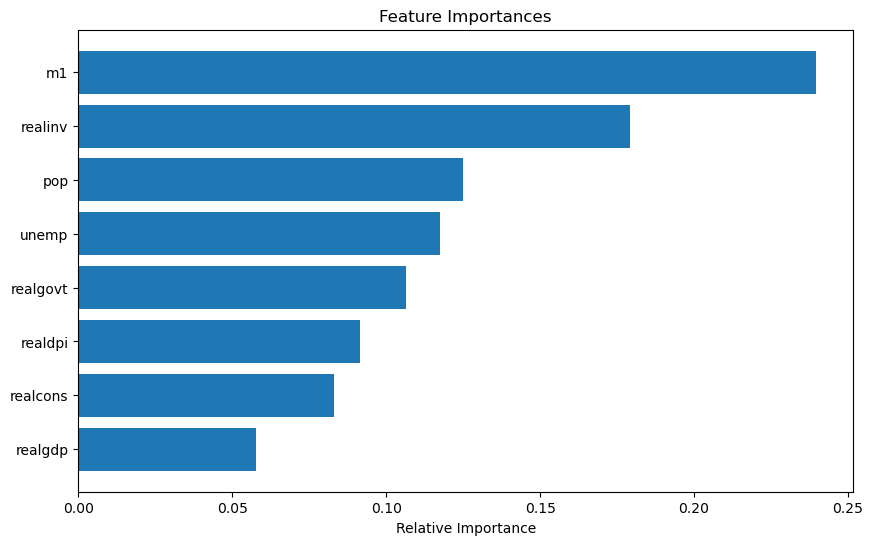

In [17]:
# Plot the most important features
importances = best_rf_clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import statsmodels.api as sm

# Load public economic data (macrodata dataset)
data = sm.datasets.macrodata.load_pandas().data

# Create a binary target variable 'high_inflation'
# Label as 1 if inflation is above the median, otherwise 0
median_infl = data['infl'].median()
data['high_inflation'] = (data['infl'] > median_infl).astype(int)

# Define features and target for classification
features = ['realgdp', 'realcons', 'realinv', 'realgov', 'cpi', 'unemp', 'pop']
target = 'high_inflation'

X = data[features]
y = data[target]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define the Random Forest Classifier and the hyperparameter grid for tuning
rf_clf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Use GridSearchCV to tune the Random Forest Classifier
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Retrieve the best estimator
best_rf_clf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Make predictions on the test set
y_pred = best_rf_clf.predict(X_test)

# Evaluate the classifier using Accuracy and Classification Report
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score:", acc)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the most important features
importances = best_rf_clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()


Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
R² Score: 0.6018585784696686
Mean Squared Error: 5.0028429295310985


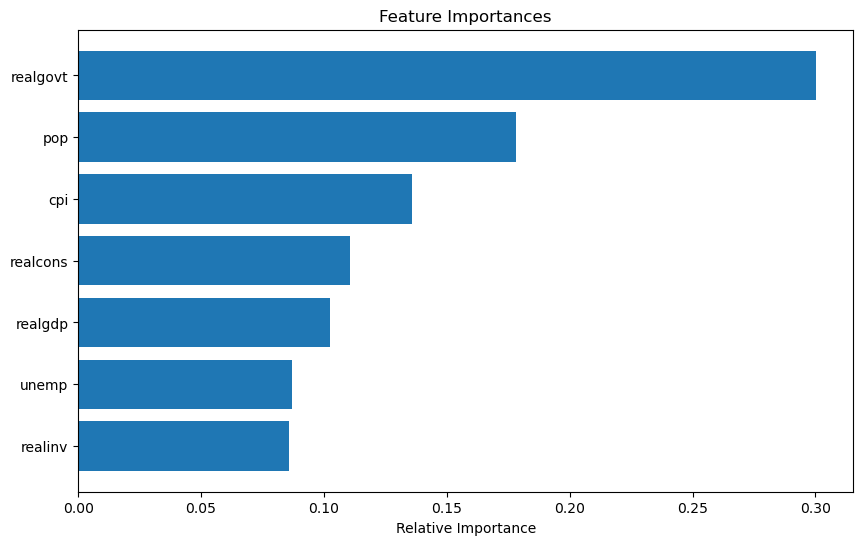

In [5]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

# Load public economic data (macrodata dataset)
# This dataset includes several macroeconomic indicators like GDP, consumption, investment, etc.
data = sm.datasets.macrodata.load_pandas().data

# For this example, we use the following columns:
# Features: 'realgdp', 'realcons', 'realinv', 'realgov', 'cpi', 'unemp', 'pop'
# Target: 'infl' (inflation rate)
features = ['realgdp', 'realcons', 'realinv', 'realgovt', 'cpi', 'unemp', 'pop']
target = 'infl'

X = data[features]
y = data[target]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the Random Forest model and the hyperparameter grid for tuning
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Use GridSearchCV to tune the Random Forest model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Retrieve the best estimator
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Make predictions on the test set
y_pred = best_rf.predict(X_test)

# Evaluate the model using R² and Mean Squared Error (MSE)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R² Score:", r2)
print("Mean Squared Error:", mse)

# Plot the most important features
importances = best_rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()
